In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
warnings.filterwarnings(action = 'ignore')

In [3]:
filename = 'default_of_credit_card_clients.xls'

### Read in dataset into Dataframe

In [4]:
def convert_to_dataframe(file):
    data = pd.read_excel(filename) # convert dataset into dataframe
    cols = data.iloc[0] # Select the row that has the column names
    data.drop(index = 0, inplace = True) #  Remove first row because it has the column names
    data.columns = cols # rename the columns with their true names
    data.rename(columns = {data.columns[-1]:'_'.join(data.columns[-1].split())}, inplace = True)
    return data

In [5]:
df = convert_to_dataframe(filename) # read filename to dataframe

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Exploratory Data Analysis (EDA)

In [7]:
print("Number of Rows: {}".format(df.shape[0]))
print("Number of Features: {}".format(df.shape[1]))

Number of Rows: 30000
Number of Features: 25


Let's check for features for any missing values.

In [8]:
ismissing_values = sum(df.isnull().sum().values) # zero missing values
print("Number of missing values: {}".format(ismissing_values))

Number of missing values: 0


The outcome variable I will be predicting is **default_payment_next_month**. I want to find the number of occurences between the categories.

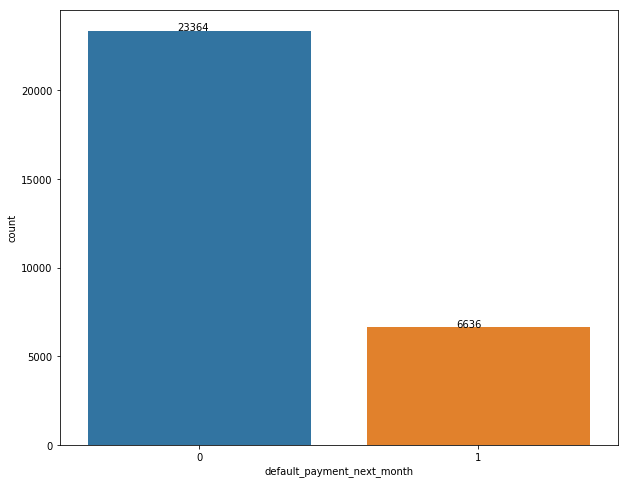

In [9]:
plt.figure(figsize = (10,8))
ax = sns.countplot(x = df.default_payment_next_month)
for p in ax.patches:
    count = '{:.0f}'.format(p.get_height())
    ax.annotate(count, (p.get_x() + 0.32, p.get_height()))

By looking at the bar graph above, there is a highly imbalance between default(0) and not default(1). This could cause an issue  with a supervised learning algorithm. Sometimes it could only learn based on the dominant label (default(0)) instead of both labels. 

Since the input features are cast as an object, let's convert it an integer, so I can see correlations between the features.I  want to check for co-linearity. 

In [10]:
main_features = df.columns[1:] # input feature columns
sub_df = df.copy() # make a copy of the original dataframe 
sub_df = sub_df.loc[:,main_features].astype('float64') # convert object to floating point numbers

Pearson correlation:

- No correlation = 0
- Some correlation = 0 - 0.3
- Fairly correlated = 0.3 - 0.5
- Moderately correlated = 0.5 - 0.7
- Strongly correlated = 0.7 - 1

Below, there is very high correlation between the **BILL_AMT** and Moderate correlation between the **PAY** features. In this case, we can either remove half of the features for both **BILL_AMT** and **PAY** or perform so sort of dimensionality reduction technique to make them uncorrelated. I would prefer to keep the features and perform Principal Component Analysis on them. 

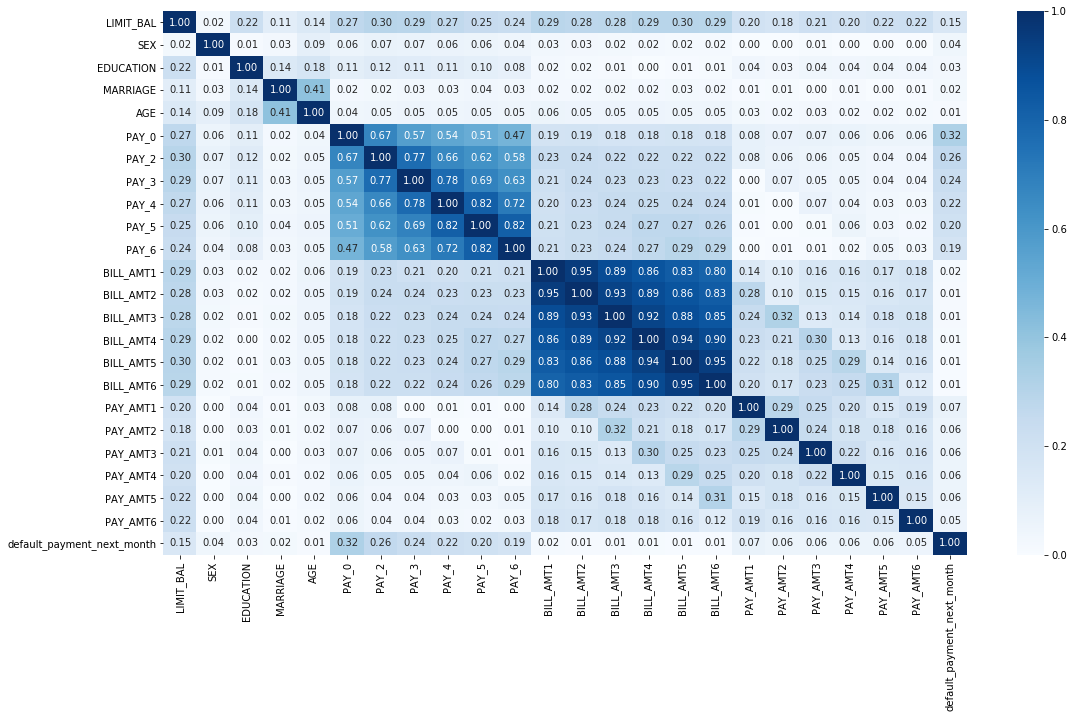

In [11]:
plt.figure(figsize = (18,10))
sns.heatmap(sub_df.corr().abs(), cmap = cm.Blues, fmt = ".2f", annot = True)
plt.xlabel("")
plt.ylabel("")
plt.show()

If you look below at the highly correlated features, **BILL_AMT1** and **BILL_AMT2**, it will not be able to discriminate between if an individual will go into default or not. Let's look at one more plot of **PAY_0** and **PAY_2**. A supervised classifier will have a hard time with these features. 

<Figure size 864x576 with 0 Axes>

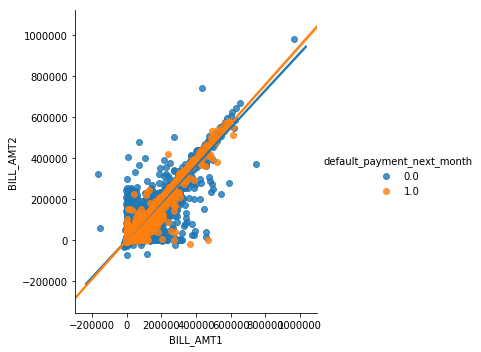

In [12]:
plt.figure(figsize = (12,8))
sns.lmplot(x = 'BILL_AMT1',y = 'BILL_AMT2', data = sub_df, hue = 'default_payment_next_month') 

Like above, these features would not be great discriminators to determine if a individual they will go into default or not,since they are moderately correlated with each other.

<Figure size 576x576 with 0 Axes>

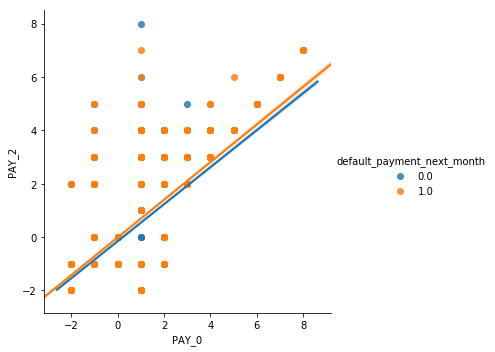

In [13]:
plt.figure(figsize = (8,8))
sns.lmplot(x = 'PAY_0',y = 'PAY_2', data = sub_df, hue = 'default_payment_next_month') 
plt.show()

Next, I want to further explore for possible outliers in the data by checking 23 features below. I will ignore the ID feature.

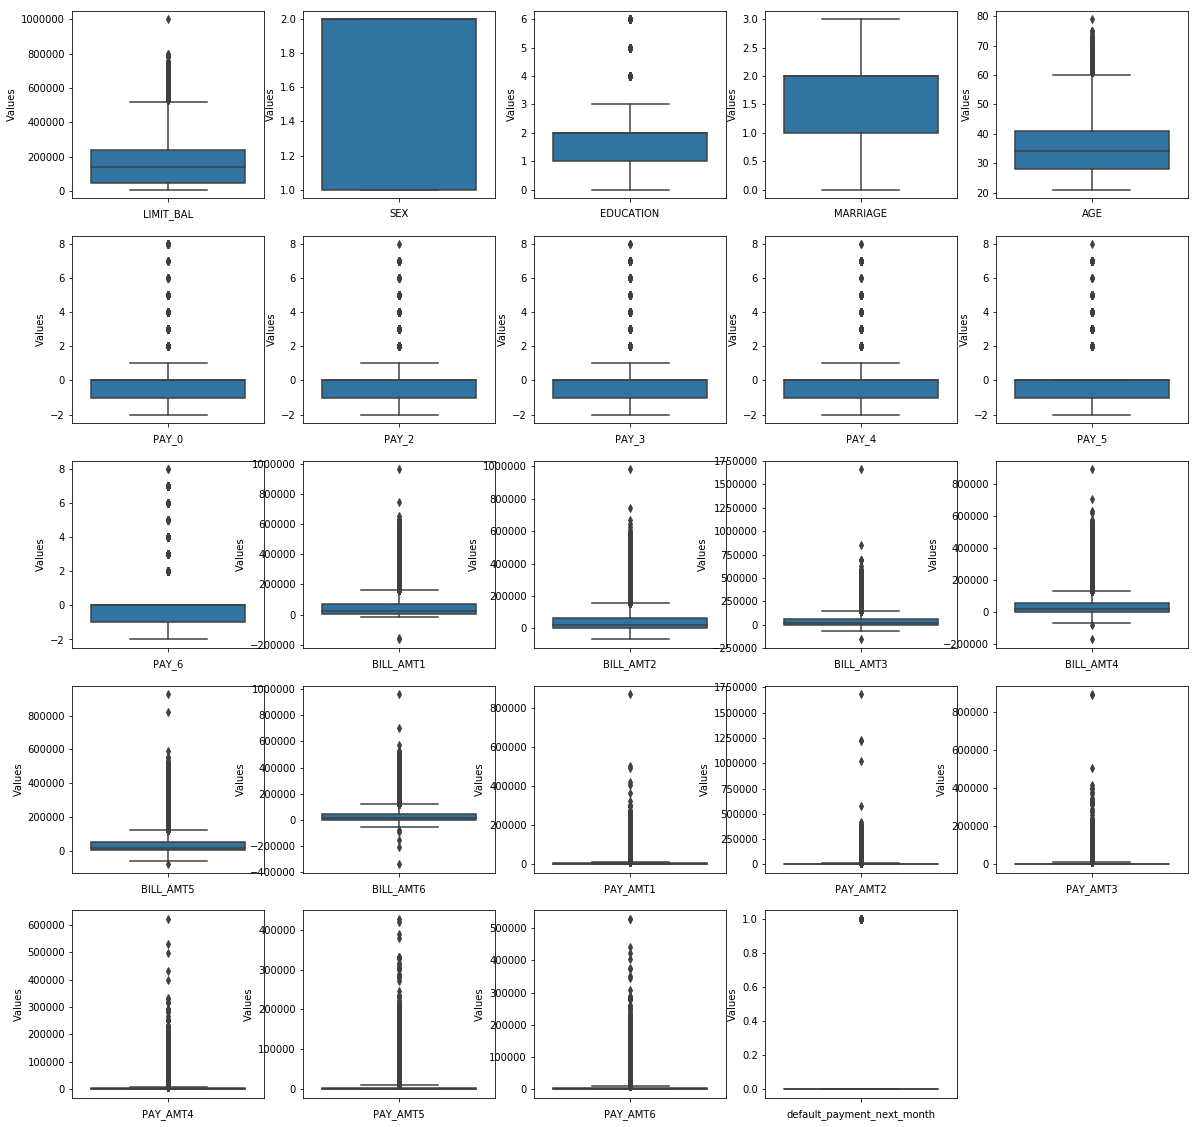

In [14]:
plt.figure(figsize = (20,20))
for i in range(sub_df.shape[1]):
    plt.subplot(5,5,i+1)
    sns.boxplot(y = sub_df.iloc[:,i])
    plt.ylabel('Values')
    plt.xlabel(sub_df.columns[i])

Above, some of these outliers may be good or bad but it depends on how the classification algorithm performs. So for now, I will keep them for now. 

In [15]:
X = sub_df.iloc[:,:-1]
y = sub_df.default_payment_next_month.astype(int) # conver to integer, instead of string object

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train,random_state = 42)

In [17]:
print("Number of Training Samples: {}".format(X_train.shape[0]))
print("Number of Validation Samples: {}".format(X_test.shape[0]))
print("Number of Testing Samples: {}".format(X_valid.shape[0]))

Number of Training Samples: 18000
Number of Validation Samples: 6000
Number of Testing Samples: 6000


## Feature Engineering

Let's standardize the input features since most of the features have very small and large ranges. 

In [18]:
standardize = StandardScaler()
X_train_scaled = standardize.fit_transform(X_train) # training set
X_valid_scaled = standardize.transform(X_valid) # validation set
X_test_scaled = standardize.transform(X_test) # test set

Next, I want to use a dimensionality technique called PCA to reduce multi-collinearity between the input features so they can become uncorrelated.

In [19]:
pca = PCA()
X_train_scaled = pca.fit_transform(X_train_scaled)
X_valid_scaled = pca.transform(X_valid_scaled)
X_test_scaled = pca.transform(X_test_scaled)

Now, let's see if I can discriminate default between the 1st and 2nd Component. 

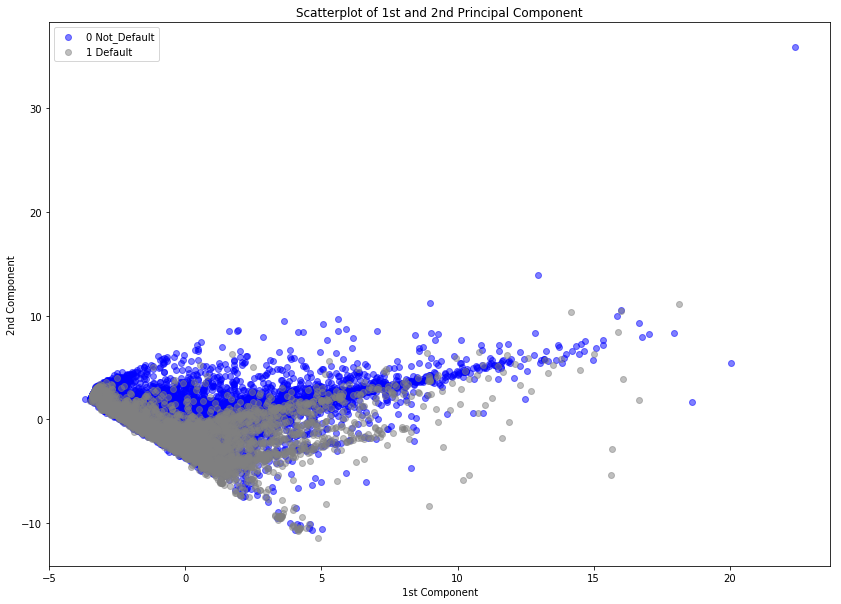

In [20]:
plt.figure(figsize = (14,10))
clist = ['blue','gray']
d = ['Not_Default','Default']
for g in [0,1]:
    ix = y_train == g
    plt.scatter(X_train_scaled[ix, 0], X_train_scaled[ix,1], label = str(g) +' '+ d[g], c = clist[g], alpha = 0.5)
    plt.xlabel('1st Component')
    plt.ylabel('2nd Component')
    plt.title("Scatterplot of 1st and 2nd Principal Component")
    plt.legend()

As we can see above, it very difficult separate between default and not default using only two components. 

## Model Building 

Next, its time to find the best performing model. The Stratified K-Fold CV is a technique used to preserve the percentage of samples for each class given the number of splits. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. Since this is a reasonably sized data set, we will perform k = 10 folds. The value for k is choosen such that each train/valid group of data samples is large enough to be representative of the boarder dataset.

In [21]:
# Try out several supervised learning classifiers to find the best performing algorithm. 
seed = 1
models = []
models.append(('SGD', SGDClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))


results = {}
scoring = ['accuracy','f1_weighted','f1','roc_auc']
for name, model in models:
    for scores in scoring:
        skfold = StratifiedKFold(n_splits = 10, random_state = seed)
        cv_results = cross_val_score(model, X_train_scaled, y_train, cv = skfold, scoring = scores)
        results[name] = {scores:cv_results.mean()}
        result = "{}:{} = {}".format(name, scores, cv_results.mean())
        print(result)

SGD:accuracy = 0.7542799702338728
SGD:f1_weighted = 0.7456418136867183
SGD:f1 = 0.36265899941400265
SGD:roc_auc = 0.6407964065352771
DT:accuracy = 0.7188329290808081
DT:f1_weighted = 0.7233222748743288
DT:f1 = 0.3925981031969121
DT:roc_auc = 0.6089664926898222
LR:accuracy = 0.8126105630828212
LR:f1_weighted = 0.7763077051726823
LR:f1 = 0.37710457186337903
LR:roc_auc = 0.7276858435331144
RF:accuracy = 0.8005003763547114
RF:f1_weighted = 0.770854108597091
RF:f1 = 0.4073362020829074
RF:roc_auc = 0.7170157955609567
GNB:accuracy = 0.7269993795437043
GNB:f1_weighted = 0.743195359480357
GNB:f1 = 0.5005578953961778
GNB:roc_auc = 0.7064313772351495


**F1** is the weighted average between precision and recall (not taking in consideration of class imbalance)

**Weighted F1** - Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**macro**: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**micro** - Calculate metrics globally by counting the total true positives, false negatives and false positives.


It looks like LF (Logistic Regression) performed the best of out all the algorithms. The second best performing algorithm was RF (Random Forest). For LF, it had a mean score accuracy of **81.26%** and an weighted F1 Score of **77.63**, which means it has the ability to generalize unseen or new data very well. For RF, it had a mean accuracy score of **79.84%** and weighted F1 score of **77.52**, which is not too bad for a base model without performing hyperparameter tuning for a better model performance. So,I will select LF as the final model.

In [30]:
dual = [True,False]
max_iter=[50,60,70,80,90,100]
C = [0.1, 0.5,1]

param_grid = dict(dual=dual,max_iter=max_iter, C = C)

In [31]:
skfold = StratifiedKFold(n_splits = 5) # stratified sampling/ preserve the a balanced percentage of samples for each class
lg = LogisticRegression() # instantiate classifier

# gridsearch for exhausting search for parameters
lg_gridsearchcv = GridSearchCV(estimator = lg, param_grid = param_grid, scoring = 'f1_weighted', cv = skfold)

In [32]:
lg_gridsearchcv_fit = lg_gridsearchcv.fit(X_train_scaled,y_train) # training for best parameters

In [33]:
def best_parameters(x):# mapping the prameters from hypertuning
    for k,v in best_params.items():
        if k == x:
            return v

In [34]:
best_params = lg_gridsearchcv.best_params_
lg.dual = best_parameters('dual') # the optimized parameter for dual
lg.max_iter = best_parameters('max_iter') # the optimized parameter for max_iter
lg.C = best_parameters('C') # the optimized parameter for C

In [35]:
#View best hyperparameters
print('Best dual:', lg.dual)
print('Best max_iter:', lg.max_iter)
print("Best C: ",lg.C)

Best dual: False
Best max_iter: 50
Best C:  0.5


Using the hyperparameters above, we will need to retrain the Logistic Regression model. 

In [36]:
lg_fit = lg.fit(X_train_scaled,y_train) # retrain using hyperparameters

Next, we will use the training and validation samples to measure the performance of the hypertuned parameters. The metrics will consist of accuracy, weighted F1 Score, and ROC_AUC.

In [37]:
lg_train_predictions_accuracy = lg.score(X_train_scaled,y_train) * 100
lg_valid_predictions_accuracy = lg.score(X_valid_scaled, y_valid) * 100
lg_test_predictions_accuracy = lg.score(X_test_scaled,y_test) * 100


lg_train_predictions_weighted_f1 = f1_score(y_train,lg.predict(X_train_scaled), average = 'weighted') * 100
lg_valid_predictions_weighted_f1 = f1_score(y_valid, lg.predict(X_valid_scaled), average = 'weighted') * 100
lg_test_predictions_weighted_f1 = f1_score(y_test, lg.predict(X_test_scaled), average = 'weighted') * 100


lg_train_predictions_roc_auc = roc_auc_score(y_train,lg.predict_proba(X_train_scaled)[:,1], average = 'weighted') * 100
lg_valid_predictions_roc_auc = roc_auc_score(y_valid, lg.predict_proba(X_valid_scaled)[:,1], average = 'weighted') * 100
lg_test_predictions_roc_auc = roc_auc_score(y_test, lg.predict_proba(X_test_scaled)[:,1], average = 'weighted') * 100

In [38]:
print('Training accuracy: {}'.format(round(lg_train_predictions_accuracy,2)))
print('Validation accuracy: {}'.format(round(lg_valid_predictions_accuracy,2)))
print('Testing accuracy: {}'.format(round(lg_test_predictions_accuracy,2)))

print()
print('Training Weighted F1: {}'.format(round(lg_train_predictions_weighted_f1,2)))
print('Validation Weighted F1: {}'.format(round(lg_valid_predictions_weighted_f1,2)))
print('Testing Weighted F1: {}'.format(round(lg_test_predictions_weighted_f1,2)))

print()
print('Training Weighted ROC AUC: {}'.format(round(lg_train_predictions_roc_auc,2)))
print('Validation Weighted ROC AUC: {}'.format(round(lg_valid_predictions_roc_auc,2)))
print('Testing Weighted ROC AUC: {}'.format(round(lg_train_predictions_roc_auc,2)))

Training accuracy: 81.32
Validation accuracy: 81.1
Testing accuracy: 81.27

Training Weighted F1: 77.72
Validation Weighted F1: 77.42
Testing Weighted F1: 77.52

Training Weighted ROC AUC: 72.99
Validation Weighted ROC AUC: 70.87
Testing Weighted ROC AUC: 72.99


Below is a dataframe of the test set probabilities with it's corresponding index.

In [39]:
lg_test_probabilites = lg.predict_proba(X_test_scaled).max(axis = 1) # predicted probabilities on the testing set
predicted_prob_df = pd.DataFrame({'test_index':X_test.index,'test_probabilites':lg_test_probabilites, 
                                  'test_predictions':lg.predict(X_test_scaled),'true_class':y_test})

In [40]:
predicted_prob_df.head(5)

,test_index,test_probabilites,test_predictions,true_class
18317,18317,0.745825,0,1
1483,1483,0.859275,0,0
10397,10397,0.942538,0,1
9361,9361,0.892365,0,0
18145,18145,0.893083,0,0


Based on the performance above, the training set performed very well against itself as expected with an accuracy of 81.32%. The validation set had an accuracy of 81.1, the testing set had a score of 81.27 and there were no indications of overfitting. There was on a small margin difference between the two which is acceptable. The second scoring metric ws F1 Score, which combines precision and recall relative to a specific positive class. It can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0. The training set had a weighted F1 score of 77.72%, the validation set had a score of 77.42, and testing set had a score of 77.52%. The third scoring metric, AUC-ROC is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. The higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The training set had a weighted F1 score of 72.99%, the validation set had a score of 70.87 and testing set 72.99%.


However, there were issues trying to classify the Default(1) class. This was due to having a very low representative sample of their labels. It would be better to have more sample data or maybe more features so the classifier can discriminate between default and not default. If I had more time, a good approach would be to a Semi-Supervised method such as the AutoEncoder. I would have trained only on non-default(0) samples and measure to see if new samples would fall within same distribution. If the samples fell outside the reconstruction error, then we would assume it an outlier or default(1). 

Overall, the model performed very good. 